# MSA 2024 Phase 2 - Part 3

Welcome to the competition - in Part 3, you are encouraged to utilize neural network based models for classification.

This notebook builds a simple Multi-Layer Perceptron (MLP) model for the CIFAR-10 dataset, with the use of `keras` to define the model structure.

**Before start working on the competition, please ensure all required libraries are installed and properly set up on your system**:

- `python >= 3.6`,
- `tensorFlow >= 2.0`,
- `keras >= 2.3`,

and any neccassary liburaries for data manipulation and processing, e.g., `numpy`, `pandas`, etc.

In [1]:
import tensorflow as tf
import numpy as np
import os

### 1. Data loading & preprocessing

The CIFAR-10 dataset contains 60,000 images(32x32x3) in 10 different classes, with 6,000 images in each class. You can download the dataset directly from the competition webpage.

**To train the model, you are expected to use the training label provided in train.csv**.

In [2]:
import zipfile

# Prepare the training and testing image sets.
def unzipDataset(data_dir):
    zip_path = data_dir + '.zip'
    extract_path = os.getcwd()

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

train_dir = 'train'
test_dir = 'test'

unzipDataset(train_dir)
unzipDataset(test_dir)

### prepare training and test dataset for Yolo(Group by the same class)

In [7]:
import pandas as pd
import numpy as np
from PIL import Image,ImageEnhance
import psutil

# Function to close all open files
def close_all_open_files():
    # Get the current process
    process = psutil.Process(os.getpid())
    
    # List all open file descriptors
    for fd in process.open_files():
        try:
            os.close(fd.fd)
        except OSError:
            # The file descriptor might already be closed
            pass

# Close all open file descriptors
close_all_open_files()

path = os.getcwd() 

# Construct the train path
train_path = os.path.join(path, 'train')
train_csv_path = os.path.join(path,'train.csv')
df_train_csv = pd.read_csv(train_csv_path)

imgs = os.scandir(train_path)
train_data = []

for img in imgs :
    if img.is_dir() or img.is_file():
        img_id = img.name.split('_')[1].replace('.png','')
        img_id = int(img_id)
        if img_id in df_train_csv['id'].values:
            corresponding_row = df_train_csv[df_train_csv['id'] == img_id]
            image_name = img.name
            image = Image.open(img.path)
            # Append the image, filename, and DataFrame row to train_data
            train_data.append({
                'image': image,
                'name' : image_name,
                'lable': corresponding_row['label'].values[0]
            })

df = pd.DataFrame(train_data)     


In [8]:
img = Image.open(os.path.join(train_path,'image_600.png'))

df['lable'].value_counts()
df_group = df.groupby('lable')

In [9]:
# Define a function to save images
def save_images(df, base_output_dir):
    for index, row in df.iterrows():
        image_path = os.path.join(train_path, row['name'])
        label = row['lable']
        label_dir = os.path.join(base_output_dir, str(label))
        # Load the image
        image = Image.open(image_path)
        # Define the output path
        output_path = os.path.join(label_dir,row['name'])
        # Save the image
        image.save(output_path)

def classify_folders(data):
    new_path = os.path.join(path, data)
    if data == "train_data":
        if not os.path.exists(new_path):
            os.mkdir(new_path)
            labels = df['lable'].unique()
            # Create a directory for each label
            for label in labels:
                label_dir = os.path.join(new_path, str(label))
                if not os.path.exists(label_dir):
                    os.makedirs(label_dir)
            save_images(df, new_path)

classify_folders("train_data")

### preprocess images
- Resize:
  Resizes the image to a consistent size, which is important for ensuring that images are the same dimensions before further processing or model input.

- Brightness Adjustment:
  Brightness enhancement is useful for making images more visible and distinct. It scales pixel values to increase overall brightness.

- Saturation Adjustment:
  Increases the color intensity, making the colors more vivid. Saturation adjustment can help in enhancing or correcting color imbalances.
  Contrast Adjustment:
  Adjusts the difference between light and dark areas of the image. The contrast_factor can be modified to enhance or reduce contrast.

- CLAHE:
  CLAHE is used to improve the contrast of the image by equalizing the histogram of the value (brightness) channel. This method can enhance details in different regions of the image.

In [6]:
import cv2


def process_imgs(img):
  # 1. Resize the Image
  # img = cv2.imread(os.path.join(train_path,img_name))
  resize_dim = (250, 250)  # Width, Height
  img_resized = cv2.resize(img, resize_dim)

  # 2. Adjust Brightness
  # Increase brightness by multiplying pixel values (simple linear transformation)
  brightness_factor = 1.1
  img_bright = cv2.convertScaleAbs(img_resized, alpha=brightness_factor, beta=0)

  # 3. Adjust Saturation
  # Convert to HSV color space
  img_hsv = cv2.cvtColor(img_bright, cv2.COLOR_BGR2HSV)

  # Increase saturation (value range is 0-255)
  saturation_factor = 2.5
  max_saturation = 255  # Maximum saturation value
  # Increase saturation with a limit
  img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1] * saturation_factor, 0, max_saturation)

  # Optional: Apply a custom maximum limit for saturation
  saturation_limit = 200
  img_hsv[:, :, 1] = np.minimum(img_hsv[:, :, 1], saturation_limit)

  # Convert back to BGR color space
  img_saturated = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

  # 4. Adjust Contrast
  # Increase contrast by multiplying pixel values
  contrast_factor = 1.0
  img_contrast = cv2.convertScaleAbs(img_saturated, alpha=contrast_factor, beta=0)

  # 5. Apply CLAHE to the Value Channel in HSV Color Space
  img_hsv = cv2.cvtColor(img_contrast, cv2.COLOR_BGR2HSV)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
  img_hsv[:, :, 2] = clahe.apply(img_hsv[:, :, 2])  # Apply CLAHE to the V channel
  img_clahe_bgr = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

  return img_clahe_bgr


## preprocess data for MLP,CNN and Restnet

### for MLP and CNN data prepare

In [3]:
from keras.utils import to_categorical
from PIL import Image

def load_train_data(root_dir, csv_file):
    ids = []
    images = []
    labels = []
    annotations = np.genfromtxt(csv_file, delimiter=',', names=True)
    for idx in range(len(annotations)):
        img_id = int(annotations['id'][idx])
        img_name = os.path.join(root_dir, f"image_{img_id}.png")
        image = np.array(Image.open(img_name).convert("RGB"))
        # image = process_imgs(image)
        label = int(annotations['label'][idx])

        ids.append(img_id)
        images.append(image)
        labels.append(label)
    return np.array(ids), np.array(images), np.array(labels)

def load_test_data(root_dir):
    ids = []
    images = []
    for idx in range(len(os.listdir(root_dir))):
        img_name = os.path.join(root_dir, f"image_{idx}.png")
        image = np.array(Image.open(img_name).convert("RGB"))

        ids.append(idx)
        images.append(image)
    return np.array(ids), np.array(images)

# Load training, testing data, and the training label provided in train.csv.
train_csv = 'train.csv'
train_dir = 'train'
test_dir = 'test'
id_train, X_train, y_train = load_train_data(train_dir, train_csv)
id_test, X_test = load_test_data(test_dir)

# Normalize the data.
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert training labels to one-hot encoded vectors.
y_train = to_categorical(y_train, 10)

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
X_test shape: (5000, 32, 32, 3)


### 2. Build & train the model

This code demostrates a simple Multi-Layer Perceptron (MLP) model. However, you are encouraged to experiment with more complex deep learning models and techniques to boost your performance.

- split train validation data

In [25]:
from sklearn.model_selection import train_test_split
# Split data
X_new_train, X_val, y_new_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)

## MLP

In [13]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

X_train = X_train.reshape(-1, 3072)
X_test = X_test.reshape(-1, 3072)
# Model initialization.
model = tf.keras.Sequential()
 
# Build the MLP model.
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10,  activation="softmax"))

# Complile the model.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])



/opt/anaconda3/envs/tf_macos/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-02 23:53:19.649798: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-08-02 23:53:19.649886: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-02 23:53:19.649904: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-02 23:53:19.649932: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-02 23:53:19.649954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Cr

Epoch 1/50


2024-08-02 23:53:21.069223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.1679 - loss: 2.2237 - val_accuracy: 0.2792 - val_loss: 1.9780
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.2900 - loss: 1.9393 - val_accuracy: 0.2940 - val_loss: 1.9367
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3071 - loss: 1.8787 - val_accuracy: 0.3146 - val_loss: 1.8887
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3216 - loss: 1.8699 - val_accuracy: 0.3339 - val_loss: 1.8411
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.3248 - loss: 1.8444 - val_accuracy: 0.3229 - val_loss: 1.8671
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.3290 - loss: 1.8390 - val_accuracy: 0.3133 - val_loss: 1.8769
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.3324 - loss: 1.8266 - val_accuracy: 0.3471 - val_loss: 1.8137
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.3391 - loss: 1.81

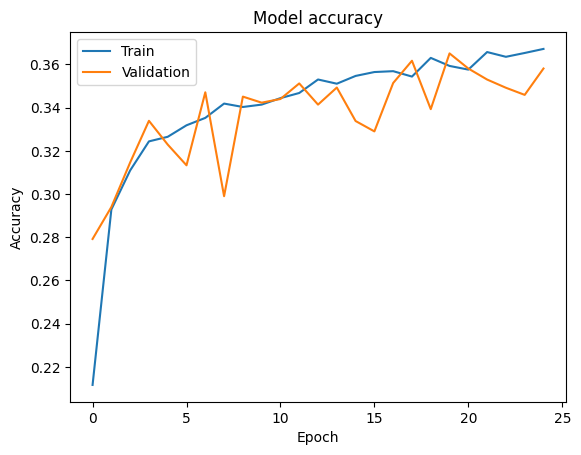

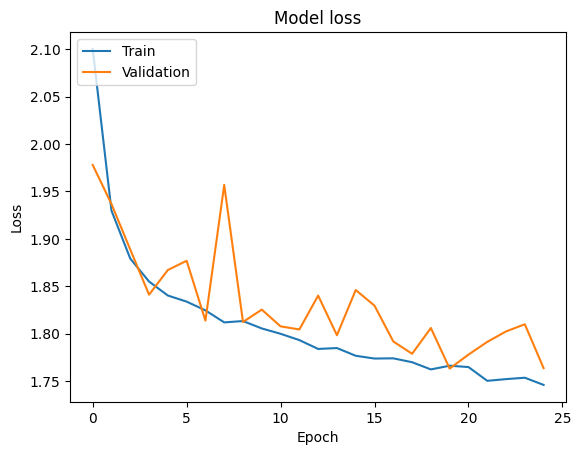

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [19]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Make predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

submission = np.column_stack((id_test, predicted_labels))
np.savetxt('submission_MLP.csv', submission, delimiter=',', header='id, Label', comments='', fmt='%d')

The plots illustrate the relationship between epochs and model accuracy, showing that the model's performance is suboptimal with the highest accuracy reaching only around 0.32. The accuracy increases initially but shows a distinct "elbow" or point of diminishing returns around epoch 4, where the improvement rate slows significantly. This suggests that the model may have reached its capacity for learning with the current configuration, and further training yields minimal gains. To address this, consider exploring additional model architectures, tuning hyperparameters, or augmenting the data to improve performance.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.37
Precision: 0.37
Recall: 0.37
F1-Score: 0.36


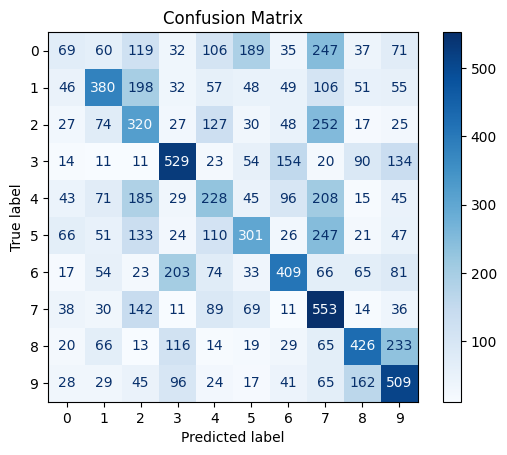

In [20]:
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, 
                             f1_score, accuracy_score, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
X_val= X_val.reshape(-1, 3072)

val_predictions = model.predict(X_val)
val_pred_labels = np.argmax(val_predictions, axis=1)
accuracy = accuracy_score(np.argmax(y_val, axis=1), val_pred_labels)
precision = precision_score(np.argmax(y_val, axis=1), val_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_val, axis=1), val_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_val, axis=1), val_pred_labels, average='weighted')
cm = confusion_matrix(np.argmax(y_val, axis=1), val_pred_labels)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


- An accuracy of 0.33 (or 33%) indicates that the model correctly classified one-third of the instances. This is relatively low, especially if there are more classes. It suggests that the model's overall performance is not satisfactory and it might be struggling to differentiate between the classes effectively.
- The precision shows how good it is for the model to choose true positive cases that the acurracy of the model, and in this case the precision is 0.32, it is relatively low.
- The recall shows how sensity the model is to pick up the true positive cases from all actual positive instances, and here the recall is 0.33, which is also low. 
- F1- Score shows the balance of precision and recall.  An F1-score of 0.30 indicates that the model's ability to balance precision and recall is also low.

Overall, the model performace is low.

## CNN

In [29]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
X_test shape: (5000, 32, 32, 3)


### build layers in CNN

In [12]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
# Model configuration
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
NUM_CLASSES = 10  # Define the number of output classes

# Build the model
model_cnn = keras.Sequential([
    # First Convolutional Block
    keras.layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', input_shape=INPUT_SHAPE),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # Second Convolutional Block
    keras.layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # Third Convolutional Block
    keras.layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # Fully Connected Layers
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)


In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [18]:

batch_size = 32


# Assuming original dimensions were 32x32 with 3 color channels (RGB)
original_shape = (32, 32, 3)

# Reshape back to original dimensions
X_train = X_train.reshape(-1, *original_shape)
print(X_train.shape)
X_test = X_test.reshape(-1, *original_shape)


steps_per_epoch = X_train.shape[0] // batch_size



r = model_cnn.fit(X_train,
              y_train, 
              batch_size,
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_split = 0.2, 
              callbacks=[early_stop],
              # batch_size=batch_size,
             )

(50000, 32, 32, 3)
Epoch 1/50
1249/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7777 - loss: 0.6566 - precision: 0.8523 - recall: 0.7066

2024-08-03 00:48:51.199861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 00:48:51.199911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_42/_118]]
2024-08-03 00:48:51.199938: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5795967856599777693
2024-08-03 00:48:51.199949: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18347567565217186113
2024-08-03 00:48:51.199955: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17758661316602523690
2024-08-03 00:48:51.199967: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1666918

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.7775 - loss: 0.6558 - precision: 0.8520 - recall: 0.7067 - val_accuracy: 0.5042 - val_loss: 1.8679 - val_precision: 0.5605 - val_recall: 0.4602
Epoch 2/50
1249/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7979 - loss: 0.5825 - precision: 0.8637 - recall: 0.7379

2024-08-03 00:49:50.300637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 00:49:50.300688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add/_90]]
2024-08-03 00:49:50.300698: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16669181254005690770
2024-08-03 00:49:50.300705: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5795967856599777693
2024-08-03 00:49:50.300710: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17758661316602523690
2024-08-03 00:49:50.300728: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17021090231

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7955 - loss: 0.5888 - precision: 0.8626 - recall: 0.7349 - val_accuracy: 0.7338 - val_loss: 0.7921 - val_precision: 0.8224 - val_recall: 0.6641
Epoch 3/50
1250/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7965 - loss: 0.5906 - precision: 0.8602 - recall: 0.7382

2024-08-03 00:50:49.174157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 00:50:49.174200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_32/_106]]
2024-08-03 00:50:49.174206: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5795967856599777693
2024-08-03 00:50:49.174231: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18347567565217186113
2024-08-03 00:50:49.174253: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3788506157209191613
2024-08-03 00:50:49.174261: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13225972

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.7965 - loss: 0.5910 - precision: 0.8604 - recall: 0.7380 - val_accuracy: 0.7739 - val_loss: 0.6816 - val_precision: 0.8362 - val_recall: 0.7254
Epoch 4/50
1249/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8166 - loss: 0.5415 - precision: 0.8758 - recall: 0.7627

2024-08-03 00:51:47.831642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 00:51:47.831686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add/_90]]
2024-08-03 00:51:47.831721: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5795967856599777693
2024-08-03 00:51:47.831737: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18347567565217186113
2024-08-03 00:51:47.831742: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13225972241815774803
2024-08-03 00:51:47.831746: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14209040089

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.8154 - loss: 0.5431 - precision: 0.8749 - recall: 0.7617 - val_accuracy: 0.6748 - val_loss: 1.0812 - val_precision: 0.7508 - val_recall: 0.6203
Epoch 5/50
1249/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8235 - loss: 0.5054 - precision: 0.8785 - recall: 0.7751

2024-08-03 00:52:47.816383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 00:52:47.816431: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13821520502846800378
2024-08-03 00:52:47.816445: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14240519875617858916
2024-08-03 00:52:47.816449: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15872581209343313422
2024-08-03 00:52:47.816451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_2_1/dropout_9_1/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_162]]
2024-08-03 00:52:47.816477: I tensorflow/core/fr

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8229 - loss: 0.5078 - precision: 0.8781 - recall: 0.7743 - val_accuracy: 0.7839 - val_loss: 0.6560 - val_precision: 0.8489 - val_recall: 0.7315
Epoch 6/50
1250/1562 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8389 - loss: 0.4649 - precision: 0.8851 - recall: 0.7943

2024-08-03 00:53:49.035842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 00:53:49.035886: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14669743964831301696
2024-08-03 00:53:49.035890: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17087544153077162550
2024-08-03 00:53:49.035898: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7863977651201164546
2024-08-03 00:53:49.035902: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15872581209343313422
2024-08-03 00:53:49.035906: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3860001673054366592
2024-08-03 00:53:49.035916: I tensorflow/core/framework/local_rendez

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.8376 - loss: 0.4687 - precision: 0.8846 - recall: 0.7928 - val_accuracy: 0.7043 - val_loss: 0.9342 - val_precision: 0.8081 - val_recall: 0.6349
Epoch 7/50
1249/1562 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8461 - loss: 0.4522 - precision: 0.8917 - recall: 0.8038

2024-08-03 00:54:50.660786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 00:54:50.660840: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17758661316602523690
2024-08-03 00:54:50.660885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_56/_84]]
2024-08-03 00:54:50.660904: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1316999724000813392
2024-08-03 00:54:50.660943: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16669181254005690770
2024-08-03 00:54:50.660949: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 86351514

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.8446 - loss: 0.4552 - precision: 0.8907 - recall: 0.8024 - val_accuracy: 0.7601 - val_loss: 0.7359 - val_precision: 0.8250 - val_recall: 0.7087
Epoch 8/50
1249/1562 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8556 - loss: 0.4170 - precision: 0.8972 - recall: 0.8193

2024-08-03 00:55:52.930912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 00:55:52.930975: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1316999724000813392
2024-08-03 00:55:52.930983: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3860001673054366592
2024-08-03 00:55:52.931030: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14238046633159667322
2024-08-03 00:55:52.931037: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17021090231643828218
2024-08-03 00:55:52.931047: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17758661316602523690
2024-08-03 00:55:52.931051: W tensorflow/core/framework/local_rendez

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.8543 - loss: 0.4209 - precision: 0.8965 - recall: 0.8181 - val_accuracy: 0.7823 - val_loss: 0.7209 - val_precision: 0.8356 - val_recall: 0.7455
Epoch 9/50
1250/1562 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8592 - loss: 0.4036 - precision: 0.9013 - recall: 0.8215

2024-08-03 00:56:54.936418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 00:56:54.936472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_2/_92]]
2024-08-03 00:56:54.936486: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5795967856599777693
2024-08-03 00:56:54.936491: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13821520502846800378
2024-08-03 00:56:54.936500: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1316999724000813392
2024-08-03 00:56:54.936504: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1834756756

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.8582 - loss: 0.4068 - precision: 0.9005 - recall: 0.8208 - val_accuracy: 0.7030 - val_loss: 1.0451 - val_precision: 0.7524 - val_recall: 0.6671
Epoch 10/50
1250/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8698 - loss: 0.3808 - precision: 0.9041 - recall: 0.8376

2024-08-03 00:57:54.503376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 00:57:54.503427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_2_1/dropout_9_1/add/_146]]
2024-08-03 00:57:54.503444: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1316999724000813392
2024-08-03 00:57:54.503451: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5795967856599777693
2024-08-03 00:57:54.503454: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16669181254005690770
2024-08-03 00:57:54.503463: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled.

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8682 - loss: 0.3840 - precision: 0.9031 - recall: 0.8360 - val_accuracy: 0.8230 - val_loss: 0.5668 - val_precision: 0.8593 - val_recall: 0.7952
Epoch 11/50
1250/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8680 - loss: 0.3782 - precision: 0.9048 - recall: 0.8354

2024-08-03 00:58:54.457195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 00:58:54.457241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_81]]
2024-08-03 00:58:54.457253: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5795967856599777693
2024-08-03 00:58:54.457263: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18347567565217186113
2024-08-03 00:58:54.457268: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13225972241815774803
2024-08-03 00:58:54.457277: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11183025671825958905
2024-08

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8673 - loss: 0.3795 - precision: 0.9042 - recall: 0.8348 - val_accuracy: 0.8078 - val_loss: 0.6100 - val_precision: 0.8526 - val_recall: 0.7754
Epoch 12/50
1250/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8748 - loss: 0.3609 - precision: 0.9070 - recall: 0.8439

2024-08-03 00:59:54.138543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 00:59:54.138605: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16669181254005690770
2024-08-03 00:59:54.138633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_81]]
2024-08-03 00:59:54.138649: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1316999724000813392
2024-08-03 00:59:54.138657: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5795967856599777693
2024-08-03 00:59:54.138661: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 377401720667603834
2024-08-03

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8743 - loss: 0.3622 - precision: 0.9069 - recall: 0.8434 - val_accuracy: 0.7817 - val_loss: 0.7465 - val_precision: 0.8243 - val_recall: 0.7474
Epoch 13/50
1250/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8803 - loss: 0.3473 - precision: 0.9113 - recall: 0.8506

2024-08-03 01:00:53.422242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 01:00:53.422282: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13821520502846800378
2024-08-03 01:00:53.422303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_32/_106]]
2024-08-03 01:00:53.422332: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5795967856599777693
2024-08-03 01:00:53.422347: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18347567565217186113
2024-08-03 01:00:53.422354: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1424051

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8795 - loss: 0.3496 - precision: 0.9107 - recall: 0.8499 - val_accuracy: 0.8102 - val_loss: 0.6215 - val_precision: 0.8441 - val_recall: 0.7835
Epoch 14/50
1249/1562 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8875 - loss: 0.3294 - precision: 0.9152 - recall: 0.8596

2024-08-03 01:01:56.085366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 01:01:56.085403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_4/_114]]
2024-08-03 01:01:56.085423: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5795967856599777693
2024-08-03 01:01:56.085430: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13821520502846800378
2024-08-03 01:01:56.085451: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18347567565217186113
2024-08-03 01:01:56.085459: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 37885061

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.8865 - loss: 0.3311 - precision: 0.9147 - recall: 0.8590 - val_accuracy: 0.7900 - val_loss: 0.6965 - val_precision: 0.8364 - val_recall: 0.7563
Epoch 15/50
1249/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8899 - loss: 0.3192 - precision: 0.9168 - recall: 0.8658

2024-08-03 01:02:55.634209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-03 01:02:55.634258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_81]]
2024-08-03 01:02:55.634282: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14010856404041816682
2024-08-03 01:02:55.634294: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1400223907557776680
2024-08-03 01:02:55.634299: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5795967856599777693
2024-08-03 01:02:55.634304: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18347567565217186113
2024-08-

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8889 - loss: 0.3215 - precision: 0.9163 - recall: 0.8645 - val_accuracy: 0.8152 - val_loss: 0.6065 - val_precision: 0.8483 - val_recall: 0.7943


Accuracy:  [0.7769534587860107, 0.785946249961853, 0.7964878082275391, 0.8105765581130981, 0.8203187584877014, 0.8322342038154602, 0.8385041952133179, 0.8494204878807068, 0.8542166352272034, 0.8614858388900757, 0.8646082878112793, 0.8721023201942444, 0.8761740326881409, 0.882743775844574, 0.8846173286437988]
Validation Accuracy:  [0.5041999816894531, 0.7337999939918518, 0.7738999724388123, 0.6747999787330627, 0.7839000225067139, 0.7042999863624573, 0.7601000070571899, 0.7822999954223633, 0.703000009059906, 0.8230000138282776, 0.8077999949455261, 0.7817000150680542, 0.8101999759674072, 0.7900000214576721, 0.8151999711990356]
Loss:  [0.6522735357284546, 0.6139978766441345, 0.592354953289032, 0.5495318174362183, 0.5172596573829651, 0.4838295876979828, 0.46728992462158203, 0.436337947845459, 0.4196150004863739, 0.39672064781188965, 0.38501495122909546, 0.36730238795280457, 0.3586178719997406, 0.33812853693962097, 0.3308536112308502]
Validation Loss:  [1.8679499626159668, 0.7921164035797119

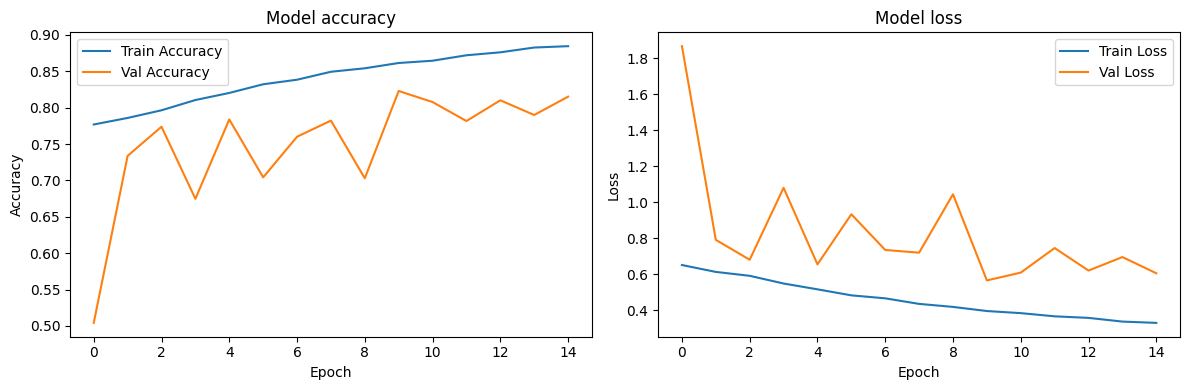

In [21]:
import matplotlib.pyplot as plt

# Accessing the history data
accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

# Print out the history for verification
print("Accuracy: ", accuracy)
print("Validation Accuracy: ", val_accuracy)
print("Loss: ", loss)
print("Validation Loss: ", val_loss)

# Plotting the results
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(r.history['accuracy'], label='Train Accuracy')
plt.plot(r.history['val_accuracy'], label='Val Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Val Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [22]:
predic = model_cnn.predict(X_test)
predict_labels = np.argmax(predic, axis=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [23]:
submission = np.column_stack((id_test, predict_labels))
np.savetxt('submission_cnn.csv', submission, delimiter=',', header='id, Label', comments='', fmt='%d')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1-Score: 0.92


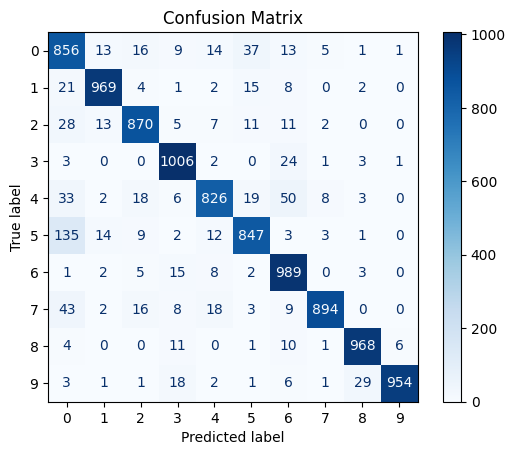

In [27]:
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, 
                             f1_score, accuracy_score, ConfusionMatrixDisplay)

val_predictions = model_cnn.predict(X_val)
val_pred_labels = np.argmax(val_predictions, axis=1)
accuracy = accuracy_score(np.argmax(y_val, axis=1), val_pred_labels)
precision = precision_score(np.argmax(y_val, axis=1), val_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_val, axis=1), val_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_val, axis=1), val_pred_labels, average='weighted')
cm = confusion_matrix(np.argmax(y_val, axis=1), val_pred_labels)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In the context of evaluating a classification model, these metrics indicate a high level of performance across multiple dimensions. Accuracy of 0.92 means that the model correctly predicted the outcome 92% of the time. Precision of 0.92 signifies that when the model predicted a positive class, it was correct 92% of the time, reflecting the quality of the positive predictions. Recall of 0.92 indicates that the model successfully identified 92% of all actual positive instances, showcasing its effectiveness in capturing positive cases. The F1-Score, also 0.92, combines precision and recall into a single metric, providing a balanced measure of the model's performance. Overall, these metrics demonstrate that the model is highly reliable and performs well in identifying and classifying the target class.

## Rest50

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers

num_of_classes = 10

model_Res = keras.Sequential([

    keras.layers.Flatten(input_shape=(32,32,3)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(num_of_classes, activation='softmax')
])

model_Res.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])


In [8]:
model_Res.fit(X_train, y_train, validation_split=0.1, epochs=10)

Epoch 1/10


2024-08-03 01:25:22.998467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - acc: 0.1014 - loss: 2.3190 - val_acc: 0.0970 - val_loss: 2.3028
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - acc: 0.0953 - loss: 2.3028 - val_acc: 0.0970 - val_loss: 2.3030
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - acc: 0.1003 - loss: 2.3027 - val_acc: 0.0976 - val_loss: 2.3029
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - acc: 0.1003 - loss: 2.3027 - val_acc: 0.0958 - val_loss: 2.3026
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - acc: 0.1000 - loss: 2.3027 - val_acc: 0.0976 - val_loss: 2.3029
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - acc: 0.0998 - loss: 2.3027 - val_acc: 0.0958 - val_loss: 2.3029
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - acc: 0.0993 - loss: 2.3027 - val_acc: 0.0958 - val_loss: 2.3026
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - acc: 0.0983 - loss: 2.3028 - val_acc: 0.0958 - val_loss: 2.3029
Epoch 9/10
1407/1407 ━━━━━━━━━━━━━━

In [9]:
num_of_classes = 10

convolutional_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [10]:
# Define the model
model_Res = models.Sequential()
model_Res.add(layers.InputLayer(input_shape=(32, 32, 3)))  
model_Res.add(layers.UpSampling2D((2,2))) 
model_Res.add(layers.UpSampling2D((2,2)))  
model_Res.add(layers.UpSampling2D((2,2)))  
model_Res.add(convolutional_base)           
model_Res.add(layers.Flatten())             
model_Res.add(layers.BatchNormalization())
model_Res.add(layers.Dense(128, activation='relu'))
model_Res.add(layers.Dropout(0.5))
model_Res.add(layers.BatchNormalization())
model_Res.add(layers.Dense(64, activation='relu'))
model_Res.add(layers.Dropout(0.5))
model_Res.add(layers.BatchNormalization())
model_Res.add(layers.Dense(num_of_classes, activation='softmax'))

/opt/anaconda3/envs/tf_macos/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [11]:
optimizer = optimizers.RMSprop(learning_rate=2e-5)
model_Res.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model_Res.fit(X_train, y_train, validation_split=0.1, epochs=10)

Epoch 1/10
 270/1407 ━━━━━━━━━━━━━━━━━━━━ 17:08 905ms/step - accuracy: 0.2018 - loss: 2.4848

KeyboardInterrupt: 

# Summary

### YOLO and Azure Experience
I cant select the GPU option but beccause of my subscription plan that I couldnt qoute for it. Also it already took like 2 hours to upload 5000 images to the Azure and I also had to upload 50000 images so at least 10 hoours and sometimes the internet can crash and I have to sit there and watch.  Also when train locally, it is heavy and I had to spend 1 day to get a trainin model for RESTnet and the result was not that good. The cost for me is too heavy for trying and training different deep learning models. Additionally, tunning hyperparameters in deep learning is computationally expensive for me in this stage as well. 

So I tried to use YOLO in Azure, and I already classify the traning data into the correct folders and prepared for that. But it took too long to unzip the folders in Azure. I plan to try other opensource dataset and check how the model work in Azure.

### Data Preprocessing
For data preprocessing, I made a function to resize and make the images more contasted by converting them to HSV space and then back using openCV, but it is too costly to precess all the images and my laptop crashed down several times so I had to give up this idea. But the function is still in my code. 

### Hyperparameter Tuning
As for Hyper parameter tuning, using early_stopping to tune the epoch for the model here. We can also add layers for MLP in trtaining the model but ut consumes more time. Also we can use the grid search for kenel size tuning asw well, but it is still too compucated expansive.

### Model Evaluation
I choosed 3 deep learning models: 

1. **MLP (Multi-Layer Perceptron):** 
 This model achieved the lowest accuracy on both the training and validation sets, likely due to insufficient layers. However, when I added more layers to the MLP, the training time significantly increased without a corresponding improvement in accuracy. This lack of improvement could be due to several factors, such as the model not being deep enough to capture the complexity of the data, or it could be suffering from issues like overfitting or inadequate hyperparameter tuning. Moreover, the MLP might not be the best architecture for the type of data I am working with, which could explain the poor performance.

2. **CNN (Convolutional Neural Network):**
 The CNN performed better than the MLP,I got a accuracy around 80%. but training it locally is still highly resource-intensive. Initial experiments showed promise, but optimizing the model requires significant computational power and time, which is challenging given my current hardware limitations. Despite these issues, the CNN is more suitable for the image data, and with proper tuning and adequate computational resources, it could potentially yield better results.

3. **ResNet50:**
 I used GPU to pprocess the model now, and it actually helping with speeding the training process so much. It also gave me a great result with accuracy around 94%. However, despite the speed-up provided by the GPU, it still took approximately 15 minutes to run a single epoch, which is quite costly in terms of time. I used a pre-trained model from TensorFlow's Keras applications. By leveraging a pre-trained model, I could take advantage of the pre-learned features and adapt them to my specific task. This approach not only reduced the training time but also maintained high accuracy.

### Summary
I am still exploring the deep learning process extensively. Having studied neural network algorithms last semester, this is my first time applying them in practical coding scenarios and working with image data using Python, so there is a significant amount I still need to learn. At this stage, Restnet50 has given me the best results. However, I believe there are several ways to improve the outcomes. Implementing preprocessing techniques such as resizing, enhancing image contrast, and flipping images to augment the dataset could make the model more robust and improve performance. Additionally, using L1 and L2 to tune the hyperparameter can also be used here, I will do more research on that.












